## Sampling alpha and lambda parameters
... from a multivariate normal distribution 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

import dotenv
import os 

In [2]:
os.chdir('../')

In [3]:
# Load variables and paths from .env
dotenv.load_dotenv('.env')


True

In [4]:
# Read environmental variables
input_dir = os.getenv('INPUT_PATH')
out_dir = os.getenv('OUTPUT_PATH')


### Using the summary stats from the grid search to fit distribution

In [10]:
run_name = "slf_grid_broad" # folder of your grid search 
total_runs = 80 # Count of runs expected (this is only needed if you had variable #'s of runs - ie. from two rounds of parameter sampling)

stats_dir = f"{out_dir}/summary_stats/{run_name}"

In [11]:
stats = pd.read_csv(f"{stats_dir}/summary_stats_wPrecisionRecallF1FBetaAggProb.csv")
stats = stats.groupby("sample").filter(lambda x: len(x) == total_runs)

In [12]:
## Aggregating needed stats by sample

agg_dict = {
    "start":["max"],
    "alpha":["max"],
    "lamda": ["max"],
    "count_known_countries_time_window_fbeta": ["mean","std"]
}

agg_dict = {**agg_dict}

agg_df = stats.groupby("sample").agg(agg_dict)

agg_df.columns = ["_".join(x) for x in agg_df.columns.values]

In [13]:
agg_df = agg_df.rename(columns={"start_max":"start","alpha_max":"alpha","lamda_max":"lamda","count_known_countries_time_window_fbeta_mean":"fbeta"})
agg_df['st_err']=agg_df['count_known_countries_time_window_fbeta_std']/np.sqrt(50)

### Exploring possible quantile thresholds for fbeta

In [15]:
count_vals = []
min_fbeta = []

for val in range(70,100):
    subset = agg_df.loc[agg_df['fbeta']>=agg_df['fbeta'].quantile(val/100)]
    count_vals.append(len(subset.index))
    min_fbeta.append(subset['fbeta'].min())

In [16]:
sample_stats = pd.DataFrame({"quantile":range(70,100), "count":count_vals, "min_fbeta":min_fbeta}).set_index("quantile")

In [17]:
quant_threshold = 90

How many samples and what Fbeta scores are captured with each threshold?

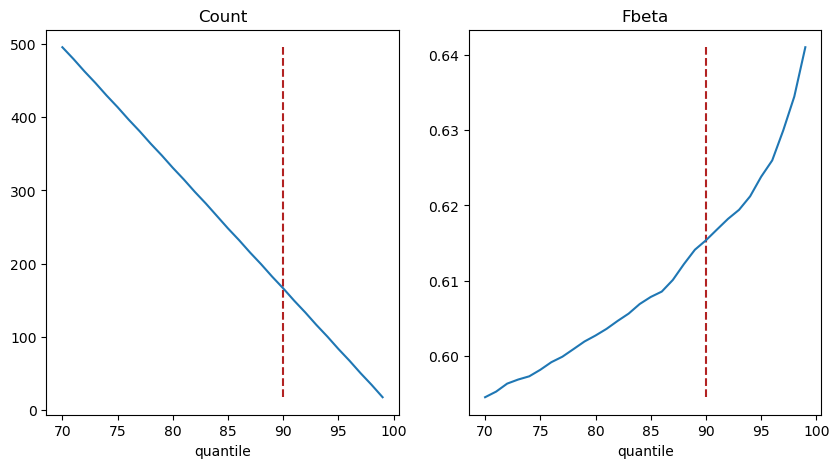

In [18]:
fig, (ax1, ax2, ) = plt.subplots(1, 2, figsize=(10, 5))
sample_stats["count"].plot(ax = ax1)
ax1.vlines(quant_threshold, ymin=sample_stats["count"].min(), ymax=sample_stats["count"].max(), linestyle='dashed', color="firebrick")
ax1.set_title("Count")

sample_stats["min_fbeta"].plot(ax = ax2)
ax2.vlines(quant_threshold, ymin=sample_stats["min_fbeta"].min(), ymax=sample_stats["min_fbeta"].max(), linestyle='dashed', color="firebrick")
ax2.set_title("Fbeta")

plt.show()

What do the distributions of alpha and lamda look like with that threshold?

In [19]:
agg_df['top']=np.where(agg_df['fbeta']>=agg_df['fbeta'].quantile(quant_threshold/100),'top','low')

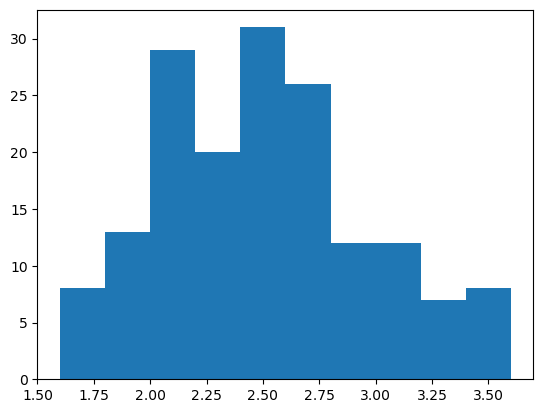

In [20]:
plt.hist((agg_df.loc[agg_df['top']=="top", "alpha"] + agg_df.loc[agg_df['top']=="top", "lamda"]).values)
plt.show()

In [77]:
## The full faceted plot - but it is slow to run (and long)

# ax = sns.relplot(x="lamda",y="fbeta", row="alpha",hue="top",palette="rocket",
#             col="start",data=agg_df,edgecolor="black",linewidth=0.5,s=100)
# plt.show()

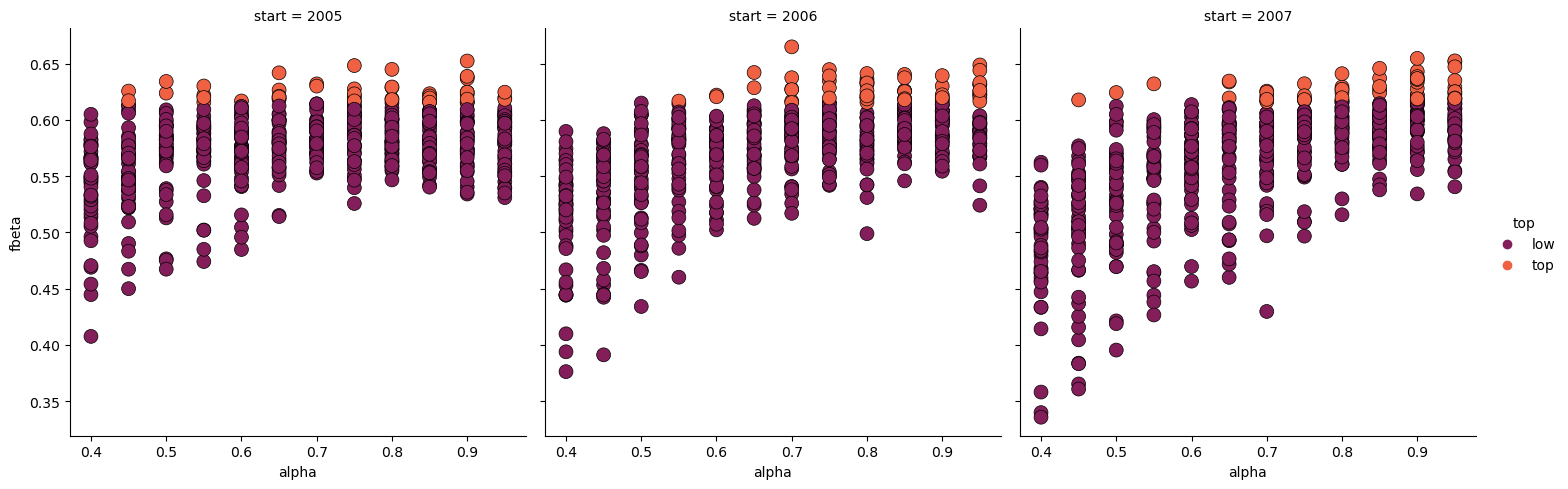

In [21]:
# Alpha by year

ax = sns.relplot(x="alpha",y="fbeta", col="start",hue="top",palette="rocket",data=agg_df,edgecolor="black",linewidth=0.5,s=100)
plt.show()

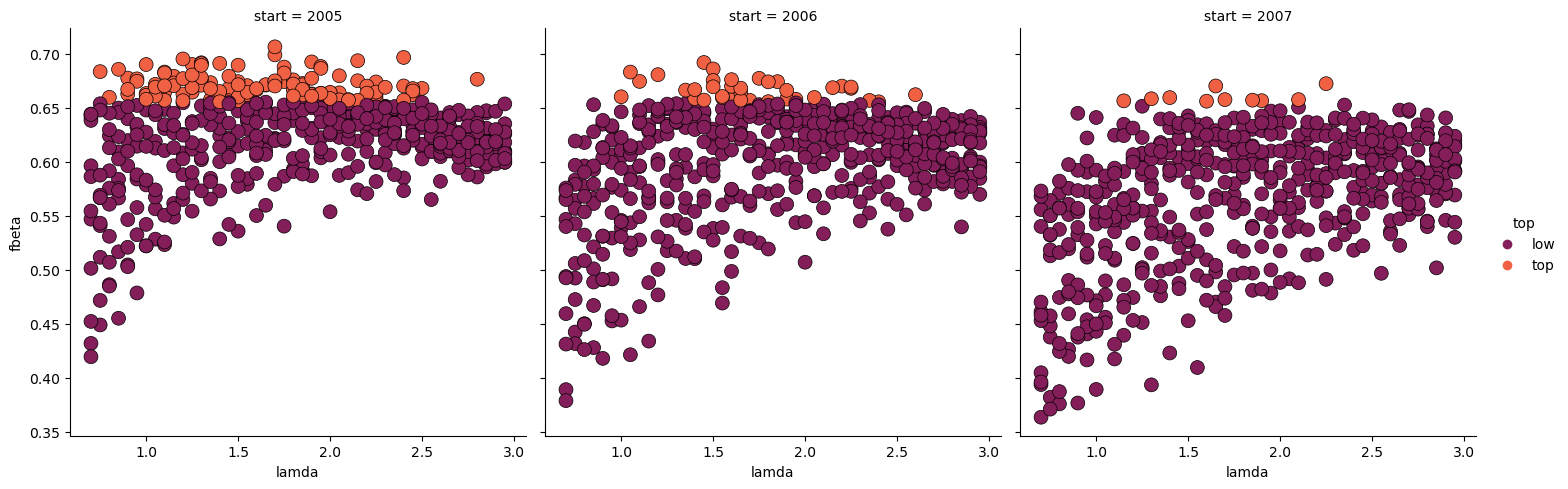

In [79]:
# Lamda by year

ax = sns.relplot(x="lamda",y="fbeta", col="start",hue="top",palette="rocket",data=agg_df,edgecolor="black",linewidth=0.5,s=100)
plt.show()

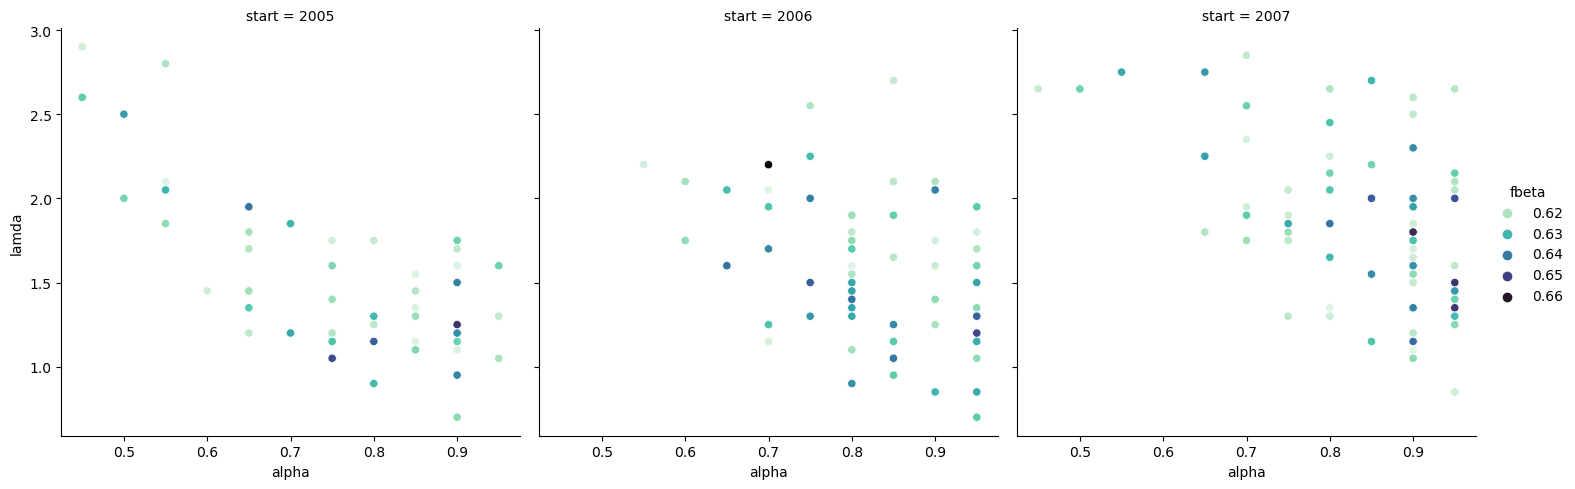

In [22]:
# Top parameter distribution plot

ax = sns.relplot(x="alpha", y="lamda", col="start", hue="fbeta", palette="mako_r", data=agg_df.loc[agg_df['top']=="top"])
plt.show()

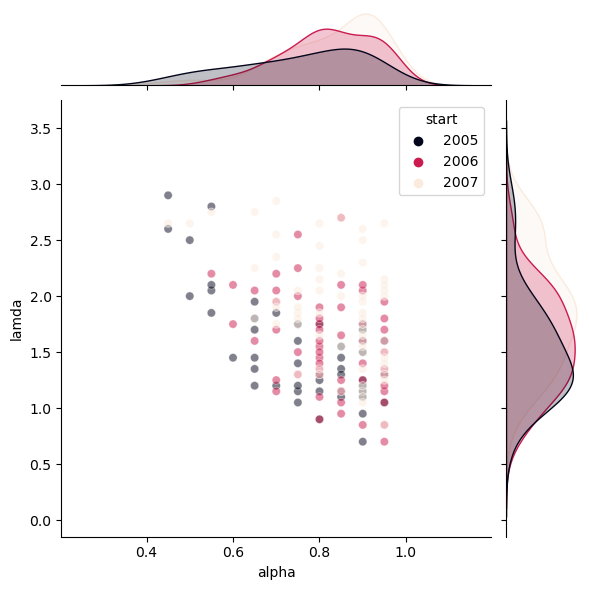

In [27]:
# Plot to visually examine - should show similar patterns to top parameter distribution plot above

ax = sns.jointplot(x="alpha", y="lamda", hue="start", data=agg_df.loc[agg_df['top']=="top"], palette="rocket", alpha = 0.5)
plt.show()

### Generating the multivariate normal distribution and sampled parameters

In [88]:
# How many distinct parameter samples?
n_samples = 1000

# How many runs per parameter sample?
n_runs = 1


In [89]:
# Fits a separate distribution per year 

param_samples_df = pd.DataFrame(columns=['alpha','lamda','start'])

for year in [2005,2006,2007]:
    top_sets=agg_df.loc[((agg_df['top']=="mid") | (agg_df['top']=="top")) & (agg_df['start'] == year)][["alpha","lamda","fbeta"]]
    param_mean = np.mean(top_sets[["alpha","lamda"]].values, axis=0)
    param_cov = np.cov(top_sets[["alpha","lamda"]].values, rowvar=0)
    param_sample = np.random.multivariate_normal(param_mean, param_cov, n_samples)
    alpha = param_sample[:,0]
    lamda = param_sample[:,1]
    start = [year]*n_samples
    param_sample_df = pd.DataFrame({"alpha":alpha, "lamda":lamda, "start":start})
    param_samples_df = pd.concat([param_samples_df, param_sample_df])

    print(f"Year: {year}, Means: {param_mean}, Covariance Matrix: {param_cov}")
    

param_samples_df = param_samples_df.loc[param_samples_df['alpha']<=1].reset_index(drop=True)

Year: 2005, Means: [0.75425532 1.53191489], Covariance Matrix: [[ 0.02106846 -0.0505192 ]
 [-0.0505192   0.23363321]]
Year: 2006, Means: [0.81964286 1.58571429], Covariance Matrix: [[ 0.01087987 -0.01748701]
 [-0.01748701  0.19515584]]
Year: 2007, Means: [0.82777778 1.87936508], Covariance Matrix: [[ 0.0137724  -0.02901434]
 [-0.02901434  0.25335765]]


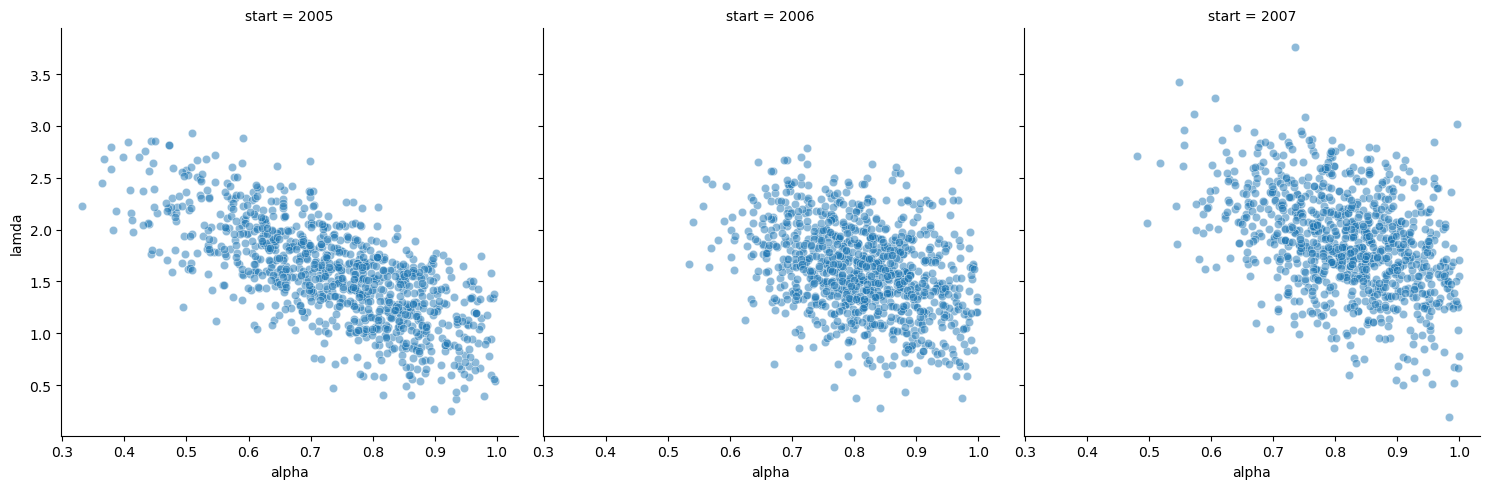

In [90]:
# Plot to visually examine - should show similar patterns to top parameter distribution plot above

ax = sns.relplot(x="alpha", y="lamda", col="start", data=param_samples_df, alpha = 0.5)
plt.show()

## Writing out sampled parameters to runs
Use this to replace the content of the commands.txt text file on HPC

In [91]:
total = len(agg_df.loc[((agg_df['top']=="mid") | (agg_df['top']=="top"))])
count2005 = len(agg_df.loc[((agg_df['top']=="mid") | (agg_df['top']=="top")) & (agg_df['start'] == 2005)])
count2006 = len(agg_df.loc[((agg_df['top']=="mid") | (agg_df['top']=="top")) & (agg_df['start'] == 2006)])
count2007 = len(agg_df.loc[((agg_df['top']=="mid") | (agg_df['top']=="top")) & (agg_df['start'] == 2007)])

In [92]:
round2005 = round(count2005/total * n_samples)
round2006 = round(count2006/total * n_samples)
round2007 = round(count2007/total * n_samples)

In [93]:
round2005 + round2006 + round2007 == n_samples

True

In [94]:
round2005 + round2006 + round2007

1000

In [95]:
samples2005 = param_samples_df.loc[param_samples_df['start']==2005].reset_index(drop=True)[0:round2005]
samples2006 = param_samples_df.loc[param_samples_df['start']==2006].reset_index(drop=True)[0:round2006]
samples2007 = param_samples_df.loc[param_samples_df['start']==2007].reset_index(drop=True)[0:round2007]

In [96]:
samples_to_run = pd.concat([samples2005,samples2006,samples2007]).reset_index(drop=True)

In [97]:
samples_to_run

,alpha,lamda,start
0,0.901945,1.231152,2005
1,0.781531,1.388689,2005
2,0.922722,0.880757,2005
3,0.863753,1.065773,2005
4,0.635789,1.848517,2005
...,...,...,...
995,0.750519,1.601151,2007
996,0.788671,1.723158,2007
997,0.707652,1.232990,2007
998,0.946642,1.826989,2007


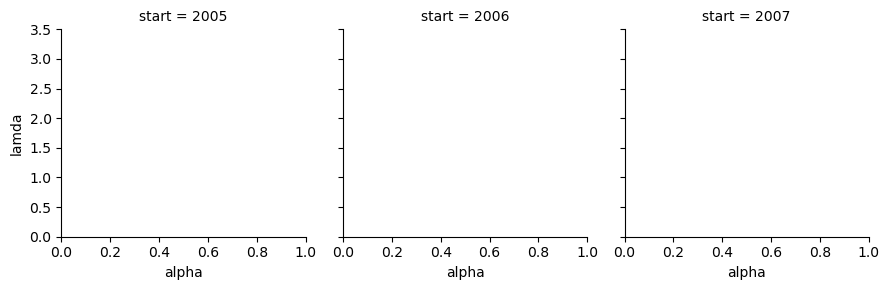

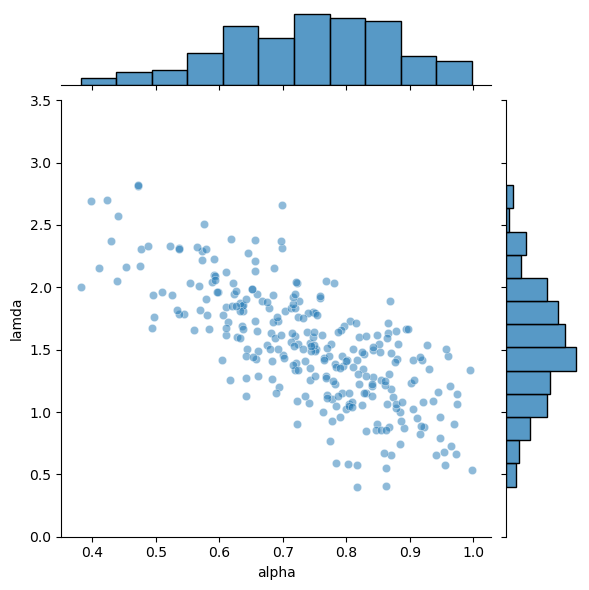

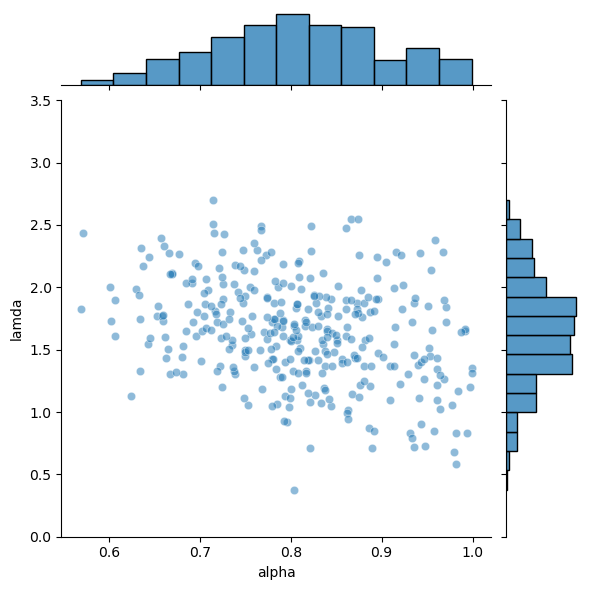

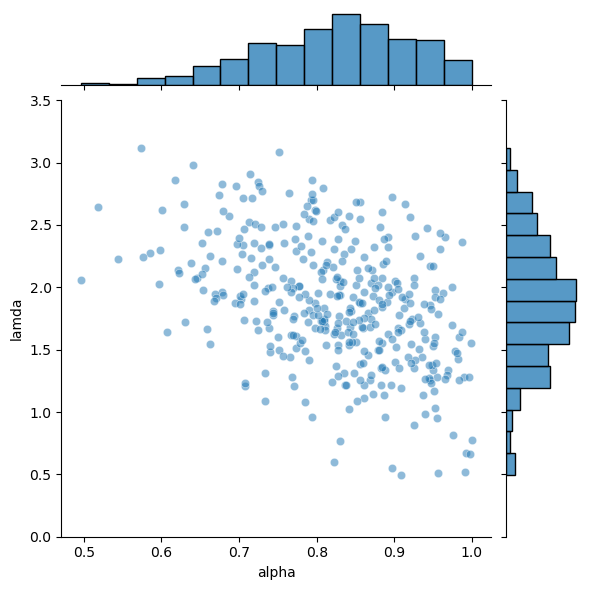

In [98]:
# Plot to visually examine - should show similar patterns to top parameter distribution plot above
g = sns.FacetGrid(samples_to_run, col="start", ylim=(0,3.50))
g.map(sns.jointplot, "alpha","lamda",alpha=0.5, ylim=(0,3.50))
plt.show()

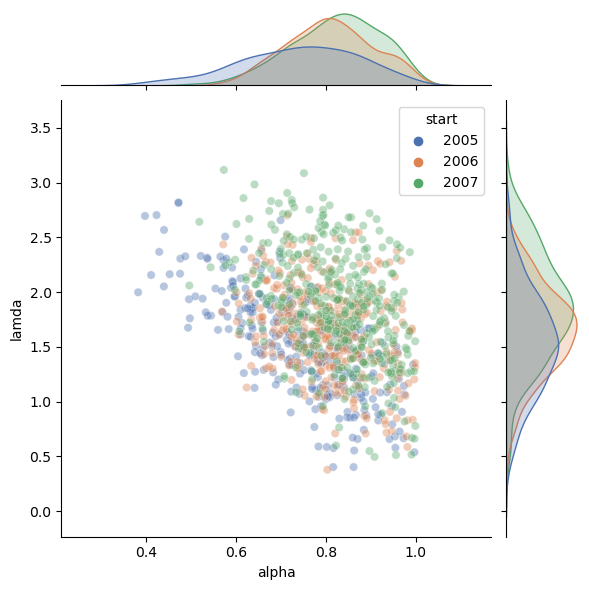

In [99]:
# Plot to visually examine - should show similar patterns to top parameter distribution plot above

ax = sns.jointplot(x="alpha", y="lamda", hue="start", data=samples_to_run, palette="deep", alpha = 0.4)
plt.show()

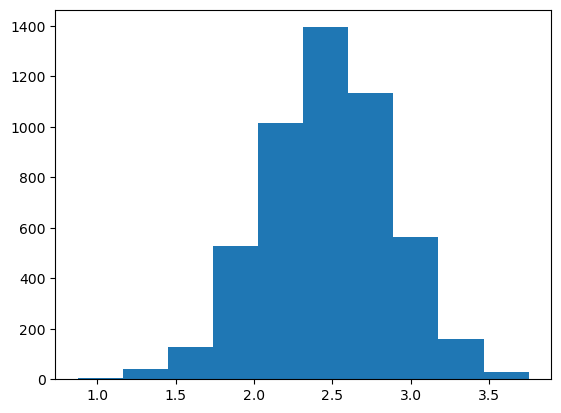

In [90]:
plt.hist(samples_to_run["alpha"] + samples_to_run["lamda"])
plt.show()

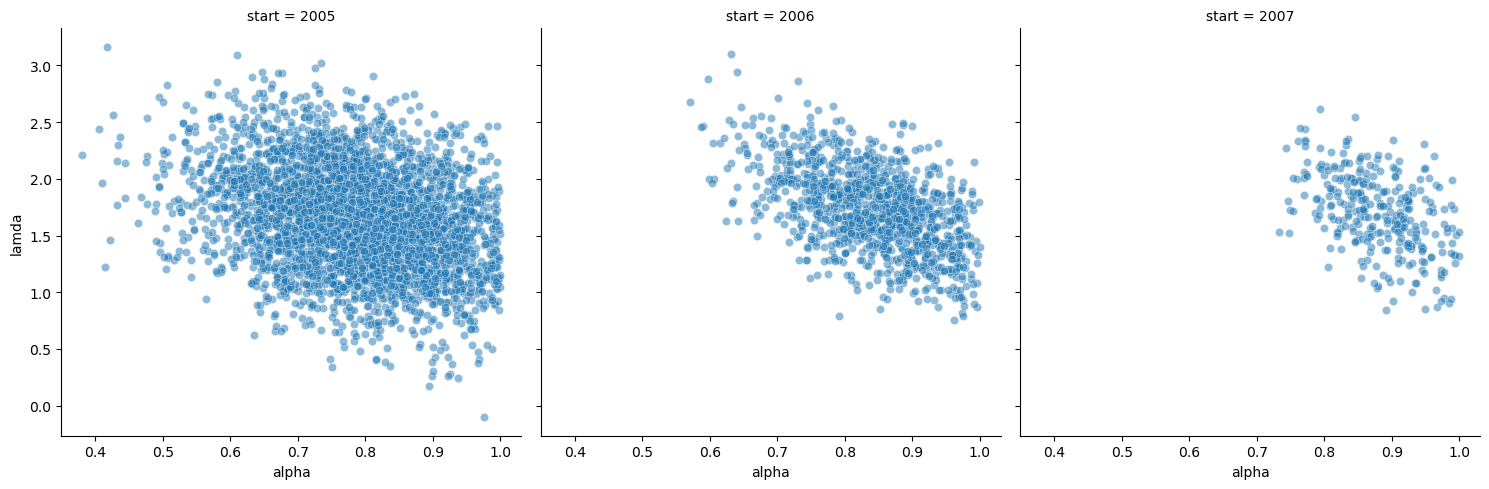

In [91]:
# Visualize samples to be run

ax = sns.relplot(x="alpha", y="lamda", col="start", data=samples_to_run, alpha = 0.5)
plt.show()

In [92]:
# Write out commands for random samples

commands = ""

start_run = 0 
end_run = n_runs - 1

script = "python model_run_args.py"

for i in samples_to_run.index:
    commands += (
        " ".join(
            [
                script,
                str(round(samples_to_run['alpha'][i],4)),
                str(round(samples_to_run['lamda'][i],4)),
                str(samples_to_run['start'][i]),
                str(start_run),
                str(end_run),
            ]
        )
        + "\n"
    )
print(commands)

python model_run_args.py 0.8122 1.8288 2005 0 0
python model_run_args.py 0.7917 1.1552 2005 0 0
python model_run_args.py 0.9266 1.9204 2005 0 0
python model_run_args.py 0.8308 1.8527 2005 0 0
python model_run_args.py 0.8409 0.7424 2005 0 0
python model_run_args.py 0.8752 1.7873 2005 0 0
python model_run_args.py 0.8071 1.3011 2005 0 0
python model_run_args.py 0.8322 1.284 2005 0 0
python model_run_args.py 0.9467 1.5238 2005 0 0
python model_run_args.py 0.6801 2.053 2005 0 0
python model_run_args.py 0.7556 1.907 2005 0 0
python model_run_args.py 0.6551 1.3428 2005 0 0
python model_run_args.py 0.7972 2.2549 2005 0 0
python model_run_args.py 0.9436 1.5565 2005 0 0
python model_run_args.py 0.8005 2.2031 2005 0 0
python model_run_args.py 0.9032 0.9245 2005 0 0
python model_run_args.py 0.8936 1.0198 2005 0 0
python model_run_args.py 0.7816 1.6568 2005 0 0
python model_run_args.py 0.8513 0.6839 2005 0 0
python model_run_args.py 0.8919 1.3686 2005 0 0
python model_run_args.py 0.9085 1.5902 2005

### Creating the aggregated stats of the sampled params
After you run the model with the sampled parameters, to generate the overall summary statistics (across samples)

In [95]:
run_name = "slf_ensemble_5000" # Set this to the name of the runs you ran with the sampled parameters
stats_dir = f"{out_dir}/summary_stats/{run_name}"


In [96]:
stats = pd.read_csv(f"{stats_dir}/summary_stats_wPrecisionRecallF1FBetaAggProb.csv")

In [100]:
# Code from summary_stats.py to define variables

sim_years = [2014,2020]
coi = "USA"

year_probs_dict_keys = []
for year in sim_years:
    year_probs_dict_keys.append(f"prob_by_{year}_{coi}")

validation_df = pd.read_csv(
        input_dir + "/noTWN/first_records_validation.csv", header=0, index_col=0,
    )

countries_dict_keys = []
for ISO3 in validation_df.index:
    countries_dict_keys.append(f"diff_obs_pred_metric_{ISO3}")

In [101]:
# Code from summmary_stats.py to define functions

def mse(x):
    return sum(x) / len(x)


def avg_std(x):
    """
    Compute average standard deviation when aggregating across runs
    of a parameter sample
    """
    return math.sqrt(sum(x ** 2) / len(x))


In [102]:
data = stats.copy()
summary_stat_path = stats_dir

In [103]:
# Code from get_stats.py to aggregate summary stats

agg_dict = {
    "start": ["max"],
    "alpha": ["max"],
    "lamda": ["max"],
    "total_countries_intros_predicted": ["mean", "std"],
    "diff_total_countries": ["mean", "std"],
    "diff_total_countries_sqrd": [mse],
    "count_known_countries_time_window": ["mean", "std"],
    "diff_obs_pred_metric_mean": ["mean"],
    "diff_obs_pred_metric_stdev": [avg_std],
    "count_known_countries_time_window_recall": ["mean"],
    "count_known_countries_time_window_precision": ["mean"],
    "count_known_countries_time_window_f1": ["mean"],
    "count_known_countries_time_window_fbeta": ["mean"],
}
prob_agg_dict = dict(
    zip(year_probs_dict_keys, ["mean" for i in range(len(year_probs_dict_keys))])
)
countries_agg_dict = dict(
    zip(
        countries_dict_keys,
        [["mean", "std"] for i in range(len(countries_dict_keys))],
    )
)

agg_dict = {**agg_dict, **prob_agg_dict, **countries_agg_dict}

agg_df = data.groupby('run_num').agg(agg_dict)

agg_df.columns = ["_".join(x) for x in agg_df.columns.values]
agg_df.to_csv(summary_stat_path + "/summary_stats_overall.csv")